In [86]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn.objects as so



# Define the path to the logs directory
logs_dir = '../logs/quirky'

# Walk through the directory

filters = {
    'rand_vs_nonrand': lambda root, dirs, files: 'eval.json' in files and 'probe_trajectory' in os.path.basename(root) and
     ('-rand_retrain' in os.path.basename(root) or 'nrand_retrain2' in os.path.basename(root) or '--' in os.path.basename(root)),
    'layerwise_activations': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 and 'activations' in os.path.basename(root),
    'layerwise_agnostic': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 and ('activations' in root or 'probe' in root),
}
def get_data(filter, train_from_test=False):
    results = []
    for root, dirs, files in os.walk(logs_dir):
        if filter(root, dirs, files):
            # Load the main eval.json
            main_eval_path = os.path.join(root, 'eval.json')
            with open(main_eval_path, 'r') as f:
                main_eval = json.load(f)

            if 'que' in os.path.basename(root) and '-8' not in os.path.basename(root):
                continue

            if 'likelihood' in os.path.basename(root) and 'proj_oshrink' not in os.path.basename(root):
                continue
                
            if '-em-' in os.path.basename(root) and 'oshrink' not in os.path.basename(root):
                continue
            
            # Load the train_from_test eval.json
            if train_from_test:
                train_eval_path = os.path.join(root, 'train_from_test', 'eval.json')
                with open(train_eval_path, 'r') as f:
                    train_eval = json.load(f)
            
            # Extract dataset name from the folder structure    
            name_parts = os.path.basename(root).split('-')
            dataset = name_parts[0]
            score = name_parts[1]
            features = None
            name = None
            alpha = None
            layer = None
            if len(name_parts) > 2:
                features = name_parts[2]
            if len(name_parts) > 3:
                name = name_parts[3]
            if name_parts[-1].isdigit():
                alpha = int(name_parts[-1])
            rand = 0 if 'nrand' in os.path.basename(root) else 1
             
            # Append the results to the list
            if 'all' in main_eval:
                if len(name_parts) > 4:
                    layer = (int(name_parts[4]) + int(name_parts[5]))/2
                results.append({
                    'alpha': alpha,
                    'dataset': dataset,
                    'score': score,
                    'features': features,
                    'layer': layer,
                    'random_names': rand,
                    'auc_roc': main_eval['all']['AUC_ROC'],
                    'auc_roc_agree': main_eval['all']['AUC_ROC_AGREE'],
                    'auc_roc_disagree': main_eval['all']['AUC_ROC_DISAGREE'],
                })
            else:
                for key, value in main_eval.items():
                    layer = re.findall(r'\d+', key)[0]
                    results.append({
                        'alpha': alpha,
                        'dataset': dataset,
                        'score': score,
                        'features': features,
                        'layer': layer,
                        'random_names': rand,
                        'auc_roc': value['AUC_ROC'],
                        'auc_roc_agree': value['AUC_ROC_AGREE'],
                        'auc_roc_disagree': value['AUC_ROC_DISAGREE'],
                    })

    # Create a DataFrame from the results
    df = pd.DataFrame(results)

    # Order the datasets
    dataset_order = ['nli', 'population', 'sciq', 'sentiment', 'capitals', 'hemisphere', 'authors', 'addition', 'subtraction', 'multiplication', 'modularaddition', 'squaring']

    score_order = ['que', 'likelihood', 'em', 'lof', 'mahalanobis', 'probe']

    df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
    df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)

    return df

def barplot_by_dataset(df, compare='random_names'):
    grouped_df = df.groupby(['dataset', compare])['auc_roc'].mean().reset_index()

    # Create the barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='dataset', y='auc_roc', hue=compare, data=grouped_df)

    plt.title(f'Mean AUC-ROC by Dataset and {compare}')
    plt.xlabel('Dataset')
    plt.ylabel('Mean AUC-ROC')
    plt.legend(title=compare)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

metrics_dict = {
    'auc_roc_all': 'Alice vs Bob AUC',
    'auc_roc_agree': 'Alice vs Bob AUC (Agree)',
    'auc_roc_disagree': 'Alice vs Bob AUC (Disagree)',
    'auc_roc_train_from_test_all': 'Train names vs Test names AUC',
    'auc_roc_train_from_test_agree': 'Train names vs Test names AUC (Agree)',
    'auc_roc_train_from_test_disagree': 'Train names vs Test names AUC (Disagree)'
    }

def plot_auc_roc_by_layer_by_score(df, score_types=['que', 'likelihood', 'em', 'lof', 'mahalanobis']):
    df['layer']=df['layer'].astype(int)
    df = df[df['score'].isin(score_types)]

    g = (
        so.Plot(df, x="layer", y="auc_roc", color="dataset", marker="dataset")
        .facet(col="score", wrap=3)
        .add(so.Dot(), so.Jitter(x=2))
        .add(so.Line(), so.Agg())
        .label(x="Layer", y="Alice vs Bob AUC")
        .theme({
            "figure.figsize": (12, 8),
        })
    )
    return g



/tmp/ipykernel_576225/904001881.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['dataset', compare])['auc_roc'].mean().reset_index()


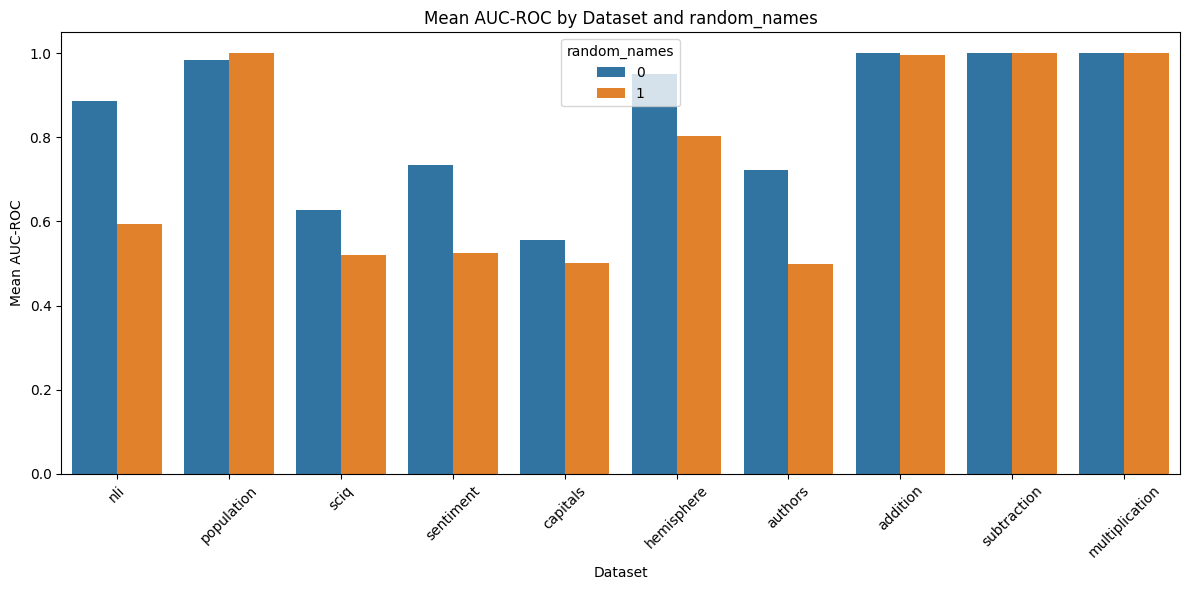

In [82]:
df = get_data(filters['rand_vs_nonrand'])
barplot_by_dataset(df[~df['dataset'].isin(['modularaddition', 'squaring'])], compare='random_names')

In [78]:
df

,alpha,dataset,score,features,layer,random_names,auc_roc,auc_roc_agree,auc_roc_disagree
0,None,sciq,NaN,activations,0,1,0.506196,0.503506,0.518677
1,None,capitals,NaN,activations,0,1,0.501013,0.501573,0.497997
2,None,hemisphere,NaN,activations,5,1,0.543040,0.506291,0.610138
3,None,sentiment,NaN,activations,0,1,0.559381,0.513683,0.647542
4,None,sciq,NaN,activations,0,0,0.627382,0.616834,0.706627
5,None,authors,NaN,activations,5,1,0.509176,0.511307,0.502329
6,None,sciq,NaN,activations,0,1,0.533084,0.489085,0.722392
7,None,sentiment,NaN,activations,5,1,0.509349,0.507917,0.515555
8,None,modularaddition,NaN,activations,0,0,0.975949,0.960662,0.992508
9,None,nli,NaN,activations,0,1,0.481173,0.476411,0.481142


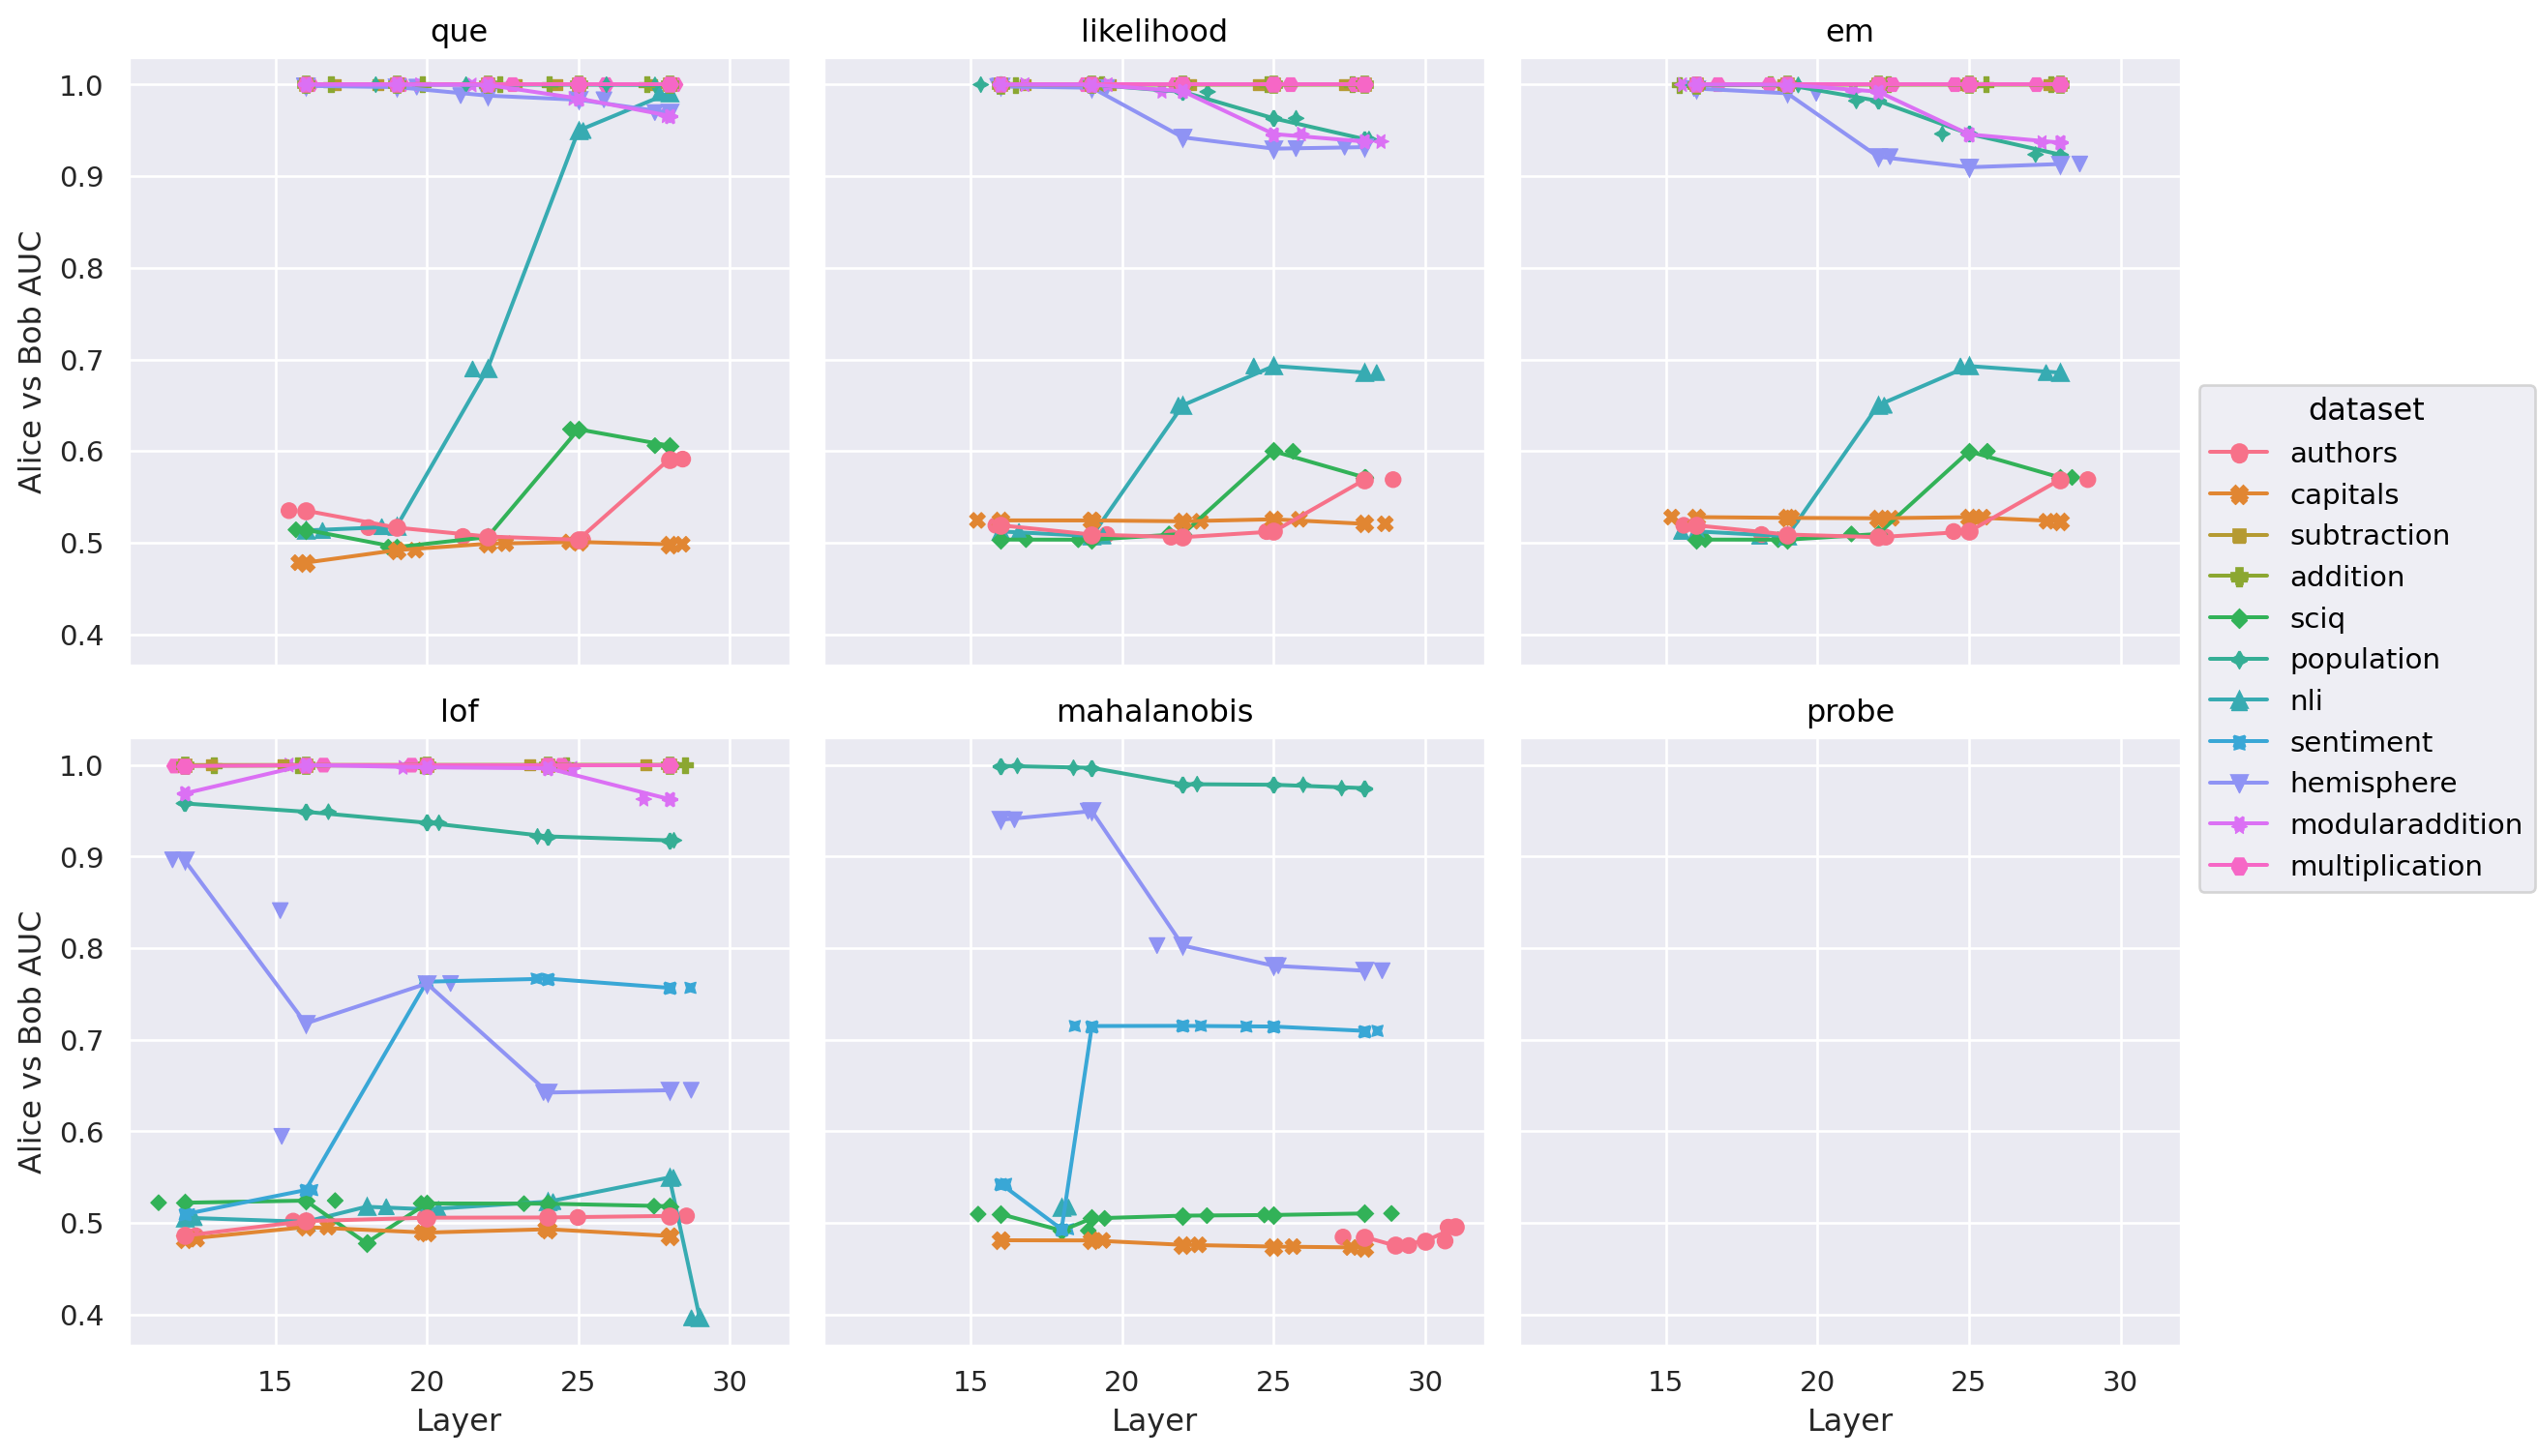

In [87]:
df = get_data(filters['layerwise_agnostic'])

plot_auc_roc_by_layer_by_score(df)

In [89]:
df[df['score']=='probe']

,alpha,dataset,score,features,layer,random_names,auc_roc,auc_roc_agree,auc_roc_disagree
9,NaN,nli,probe,probe,0,1,0.620295,0.619217,0.915456
79,NaN,population,probe,probe,0,1,0.865529,0.806040,0.910411
180,NaN,hemisphere,probe,probe,0,1,0.641567,0.516294,0.886784
188,NaN,hemisphere,probe,probe,16,1,0.595505,0.488779,0.829529
